In [1]:
# Garch
import os
import sys
import numpy as np
import pandas as pd

np.random.seed(40)  # Set the seed for reproducibility

# Check if the original directory is already saved in a variable
if 'original_directory' not in globals():
    # Save the original working directory the first time
    original_directory = os.getcwd()

# Change back to the original directory whenever the cell is executed
os.chdir(original_directory)

# Go to mother directory
os.chdir("../")

# Verify the current working directory
print("Working directory set to:", os.getcwd())

sys.path.append(os.path.abspath(os.getcwd()))


Working directory set to: c:\Users\Biebert\OneDrive - Universität St.Gallen\Dokumente\OneDrive Dokumente\02_Bildung\01_BVWL Bachelor\01_Kurse\07_Thesis\Code\Portfolio_Optimization_DDPG


In [30]:
import yfinance as yf
from arch import arch_model

np.random.seed(40) 

tickers = ['MSFT', 'TGT', 'QCOM', 'MU', 'CAT']
num_simulation_episodes = 500
num_simulation_days = 750

train_simulations = int(num_simulation_episodes * (1 - 0.2))
test_simulations = num_simulation_episodes - train_simulations
initial_price = 100


for ticker in tickers:
    sim_df_train = pd.DataFrame(index=range(num_simulation_days + 1), columns=range(train_simulations))
    sim_df_test = pd.DataFrame(index=range(num_simulation_days + 1), columns=range(test_simulations))


    data = yf.download(ticker, start="2000-01-01", end="2020-01-01")['Adj Close']
    log_returns = np.log(data / data.shift(1)).dropna()
    garch = arch_model(log_returns, p=1, q=1, dist='normal')
    res = garch.fit(disp="off")
    for i in range(num_simulation_episodes):
        simulated_log_returns = garch.simulate(res.params, num_simulation_days)
        simulated_log_returns = simulated_log_returns['data']# - res.params['mu']  # Set drift to zero for simulation

        # simulated_returns = np.exp(simulated_log_returns) - 1
        # simulated_prices = initial_price * (1 + simulated_returns).cumprod()

        cumsum = np.cumsum(simulated_log_returns)
        simulated_prices = initial_price * np.exp(cumsum)

        simulated_prices_with_initial = pd.concat([pd.Series([initial_price]), pd.Series(simulated_prices)], ignore_index=True)

        # Split the simulations into training and testing sets
        if i < train_simulations:
            sim_df_train[i] = simulated_prices_with_initial
        else:
            sim_df_test[i - train_simulations] = simulated_prices_with_initial
    print(ticker)

    sim_df_train.to_csv("data/2_sim_train_" + ticker + ".csv")
    sim_df_test.to_csv("data/2_sim_test_" + ticker + ".csv")

    sim_df_train, sim_df_test


[*********************100%%**********************]  1 of 1 completed
c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003602. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


MSFT


[*********************100%%**********************]  1 of 1 completed
c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


TGT


[*********************100%%**********************]  1 of 1 completed
c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007068. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


QCOM


[*********************100%%**********************]  1 of 1 completed
c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001308. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


MU


[*********************100%%**********************]  1 of 1 completed
c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004028. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


CAT


In [76]:
import numpy as np
import pandas as pd
import yfinance as yf
from arch import arch_model
import warnings

# Suppress DataScaleWarning only
warnings.filterwarnings("ignore")


np.random.seed(40)

tickers = ['MSFT', 'TGT', 'QCOM', 'MU', 'CAT']
num_simulation_episodes = 500
num_simulation_days = 750

train_simulations = int(num_simulation_episodes * 0.8)
test_simulations = num_simulation_episodes - train_simulations
initial_price = 100

for ticker in tickers:
    sim_df_train = pd.DataFrame(index=range(num_simulation_days + 1), columns=range(train_simulations))
    sim_df_test = pd.DataFrame(index=range(num_simulation_days + 1), columns=range(test_simulations))

    data = yf.download(ticker, start="2000-01-01", end="2020-01-01")['Adj Close']
    log_returns = np.log(data / data.shift(1)).dropna()
    
    # Fit GARCH(1,1) model
    garch = arch_model(log_returns, p=1, q=1, dist='normal')
    res = garch.fit(disp="off")
    garch_mu = res.params['mu']
    
    mean_returns = []  # Store the mean log return of each episode
    
    for i in range(num_simulation_episodes):
        # Simulate log returns using the GARCH model
        simulated_log_returns = garch.simulate(res.params, num_simulation_days)
        simulated_log_returns = simulated_log_returns['data'] # Set drift to zero for simulation
        
        # Calculate cumulative sum to get log prices
        cumsum = np.cumsum(simulated_log_returns)
        simulated_prices = initial_price * np.exp(cumsum)
        
        # Store the price paths with the initial price
        simulated_prices_with_initial = pd.concat([pd.Series([initial_price]), pd.Series(simulated_prices)], ignore_index=True)
        
        # Calculate the mean log return for this episode
        episode_log_returns = np.diff(np.log(simulated_prices_with_initial))
        mean_returns.append(np.mean(episode_log_returns))
        
        # Split into training and testing sets
        if i < train_simulations:
            sim_df_train[i] = simulated_prices_with_initial
        else:
            sim_df_test[i - train_simulations] = simulated_prices_with_initial

    # Calculate the average of the mean log returns across all episodes
    estimated_mu = np.mean(mean_returns)
    
    # Compare with GARCH model's mu
    comparison = pd.DataFrame({
        'GARCH_Mu': [garch_mu],
        'Estimated_Mu': [estimated_mu],
        'Difference': [estimated_mu - garch_mu],
        'Percent_Error': [(estimated_mu - garch_mu) / garch_mu * 100]
    })

    print(f"Comparison for {ticker}:")
    print(comparison)

    # Save simulations as CSV files
    sim_df_train.to_csv(f"data/3_sim_train_{ticker}.csv")
    sim_df_test.to_csv(f"data/3_sim_test_{ticker}.csv")


[*********************100%%**********************]  1 of 1 completed


Comparison for MSFT:
   GARCH_Mu  Estimated_Mu  Difference  Percent_Error
0   0.00069      0.000705    0.000015       2.145531


[*********************100%%**********************]  1 of 1 completed


Comparison for TGT:
   GARCH_Mu  Estimated_Mu  Difference  Percent_Error
0  0.000473      0.000479    0.000006        1.33899


[*********************100%%**********************]  1 of 1 completed


Comparison for QCOM:
   GARCH_Mu  Estimated_Mu  Difference  Percent_Error
0  0.000706      0.000792    0.000085      12.087005


[*********************100%%**********************]  1 of 1 completed


Comparison for MU:
   GARCH_Mu  Estimated_Mu  Difference  Percent_Error
0  0.000616      0.000569   -0.000047      -7.660368


[*********************100%%**********************]  1 of 1 completed


Comparison for CAT:
   GARCH_Mu  Estimated_Mu  Difference  Percent_Error
0  0.000773      0.000757   -0.000016      -2.063169


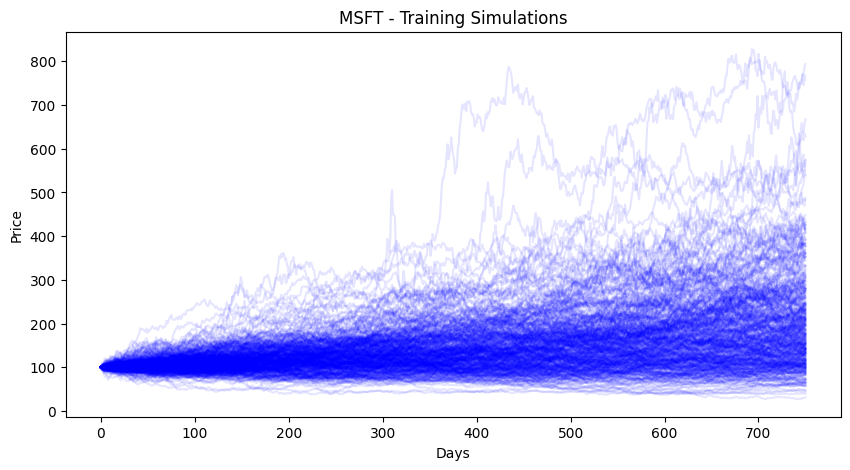

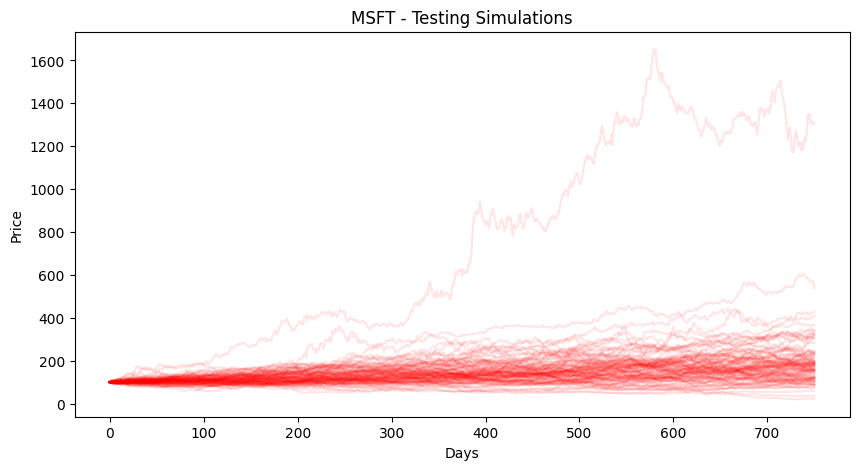

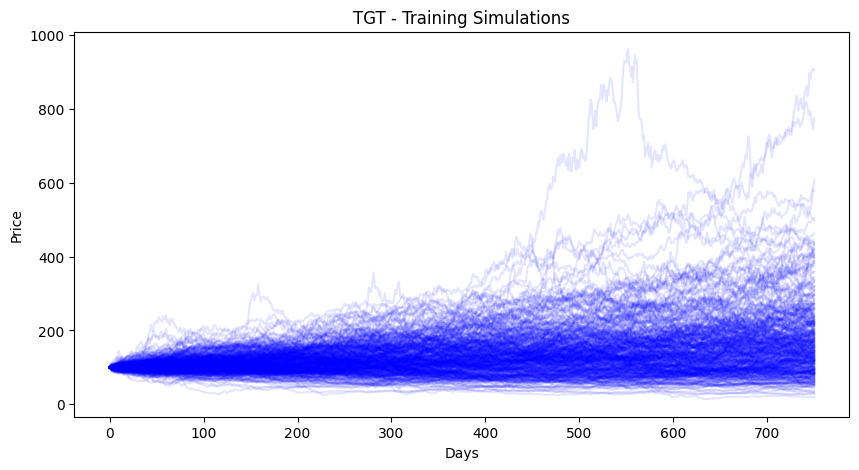

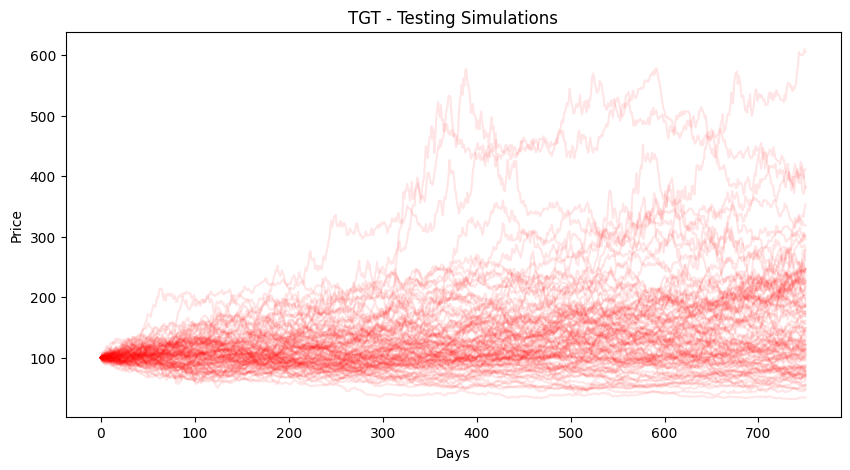

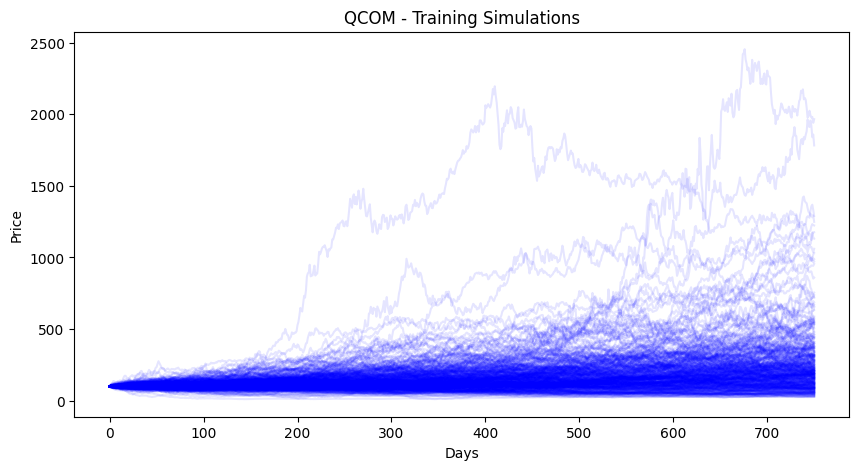

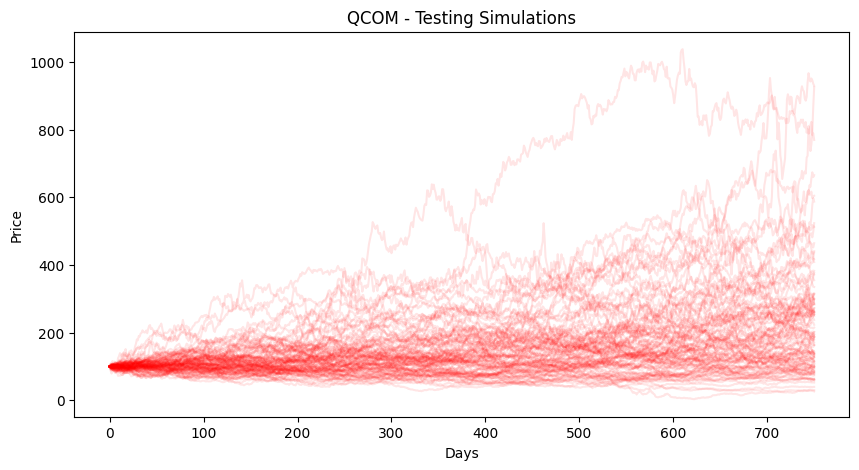

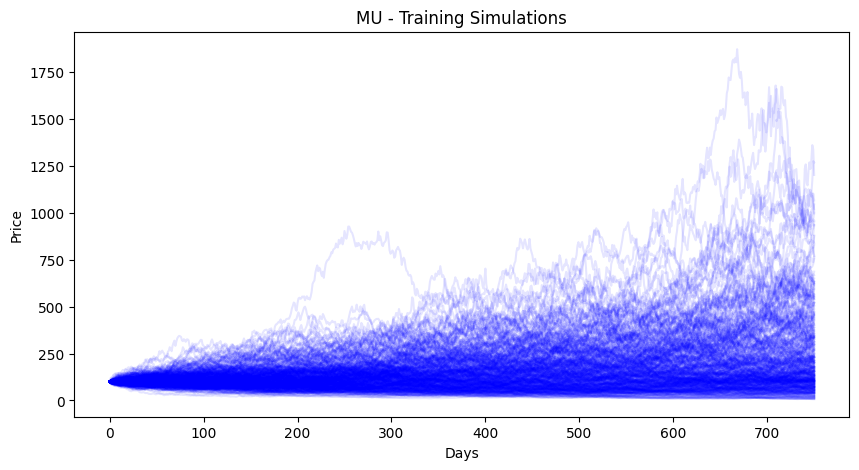

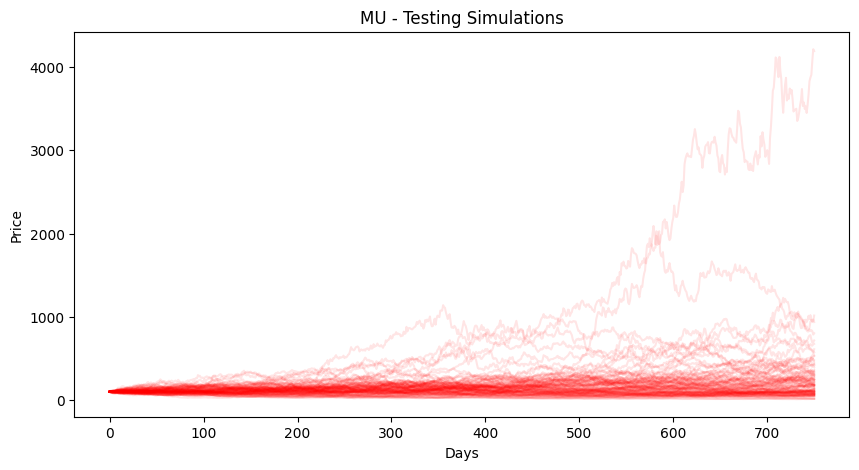

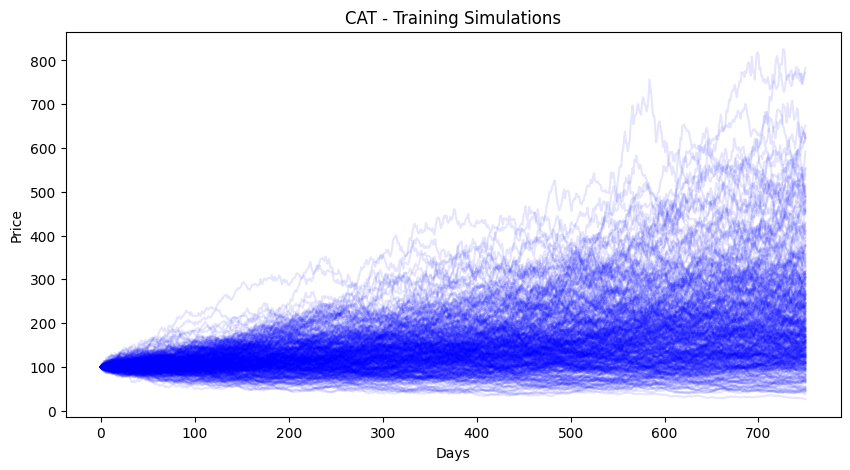

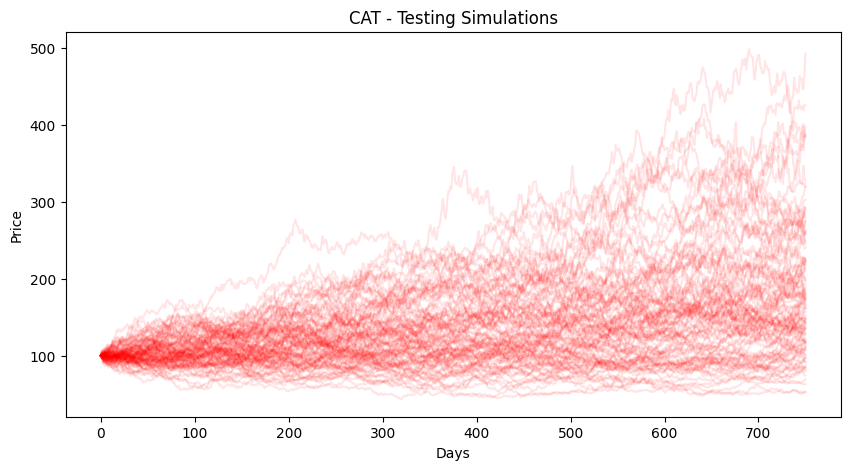

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
tickers = ['MSFT', 'TGT', 'QCOM', 'MU', 'CAT']

# Load and plot each CSV for training and testing sets
for ticker in tickers:
    # Load training and testing data
    sim_df_train = pd.read_csv(f"data/3_sim_train_{ticker}.csv", index_col=0)
    sim_df_test = pd.read_csv(f"data/3_sim_test_{ticker}.csv", index_col=0)
    
    # Plot training simulations
    plt.figure(figsize=(10, 5))
    plt.plot(sim_df_train, color="blue", alpha=0.1)
    plt.title(f"{ticker} - Training Simulations")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.show()

    # Plot testing simulations
    plt.figure(figsize=(10, 5))
    plt.plot(sim_df_test, color="red", alpha=0.1)
    plt.title(f"{ticker} - Testing Simulations")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.show()


[*********************100%%**********************]  1 of 1 completed


Comparison for MSFT:
   GARCH_Mu  Estimated_Mu  Difference  Percent_Error
0   0.00069      0.000743    0.000053       7.617432


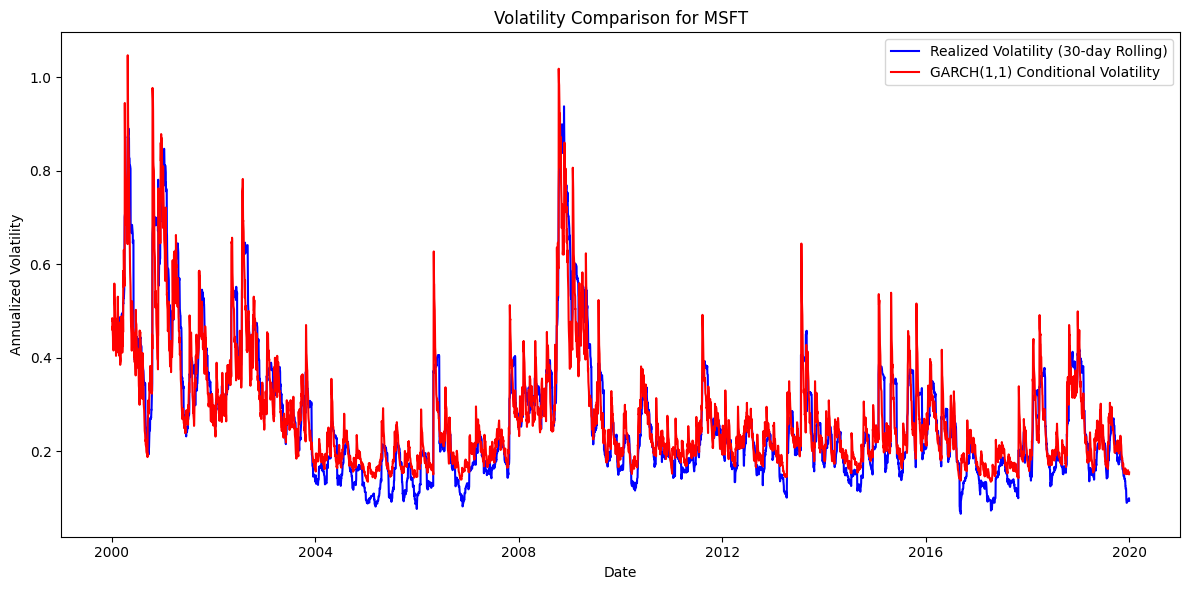

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
from arch import arch_model
import warnings
import matplotlib.pyplot as plt

# Suppress DataScaleWarning only
warnings.filterwarnings("ignore")

np.random.seed(40)

tickers = ['MSFT'] #, 'TGT', 'QCOM', 'MU', 'CAT']
num_simulation_episodes = 500
num_simulation_days = 750

train_simulations = int(num_simulation_episodes * 0.8)
test_simulations = num_simulation_episodes - train_simulations
initial_price = 100

# Create a directory to save plots if it doesn't exist
import os
if not os.path.exists("plots"):
    os.makedirs("plots")

for ticker in tickers:
    sim_df_train = pd.DataFrame(index=range(num_simulation_days + 1), columns=range(train_simulations))
    sim_df_test = pd.DataFrame(index=range(num_simulation_days + 1), columns=range(test_simulations))

    data = yf.download(ticker, start="2000-01-01", end="2020-01-01")['Adj Close']
    log_returns = np.log(data / data.shift(1)).dropna()
    
    # Calculate Realized Volatility (e.g., 30-day rolling standard deviation)
    rolling_window = 30
    realized_vol = log_returns.rolling(window=rolling_window).std() * np.sqrt(252)  # Annualize
    
    # Fit GARCH(1,1) model
    garch = arch_model(log_returns, p=1, q=1, dist='normal')
    res = garch.fit(disp="off")
    garch_mu = res.params['mu']
    
    # Obtain GARCH model's conditional volatility
    garch_vol = res.conditional_volatility * np.sqrt(252)  # Annualize
    
    mean_returns = []  # Store the mean log return of each episode

    for i in range(num_simulation_episodes):
        # Simulate log returns using the GARCH model
        simulated_log_returns = garch.simulate(res.params, num_simulation_days)
        simulated_log_returns = simulated_log_returns['data']  # Set drift to zero for simulation
        
        # Calculate cumulative sum to get log prices
        cumsum = np.cumsum(simulated_log_returns)
        simulated_prices = initial_price * np.exp(cumsum)
        
        # Store the price paths with the initial price
        simulated_prices_with_initial = pd.concat([pd.Series([initial_price]), pd.Series(simulated_prices)], ignore_index=True)
        
        # Calculate the mean log return for this episode
        episode_log_returns = np.diff(np.log(simulated_prices_with_initial))
        mean_returns.append(np.mean(episode_log_returns))
        
        # Split into training and testing sets
        if i < train_simulations:
            sim_df_train[i] = simulated_prices_with_initial
        else:
            sim_df_test[i - train_simulations] = simulated_prices_with_initial

    # Calculate the average of the mean log returns across all episodes
    estimated_mu = np.mean(mean_returns)
    
    # Compare with GARCH model's mu
    comparison = pd.DataFrame({
        'GARCH_Mu': [garch_mu],
        'Estimated_Mu': [estimated_mu],
        'Difference': [estimated_mu - garch_mu],
        'Percent_Error': [(estimated_mu - garch_mu) / garch_mu * 100]
    })

    print(f"Comparison for {ticker}:")
    # print(comparison)

    # Plotting Volatility
    plt.figure(figsize=(12, 6))
    
    # Plot Realized Volatility
    plt.plot(realized_vol.index, realized_vol, label='Realized Volatility (30-day Rolling)', color='blue')
    
    # Plot GARCH Conditional Volatility
    plt.plot(garch_vol.index, garch_vol, label='GARCH(1,1) Conditional Volatility', color='red')
    
    plt.title(f"Volatility Comparison for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Annualized Volatility")
    plt.legend()
    plt.tight_layout()

    plt.show()



[*********************100%%**********************]  1 of 1 completed


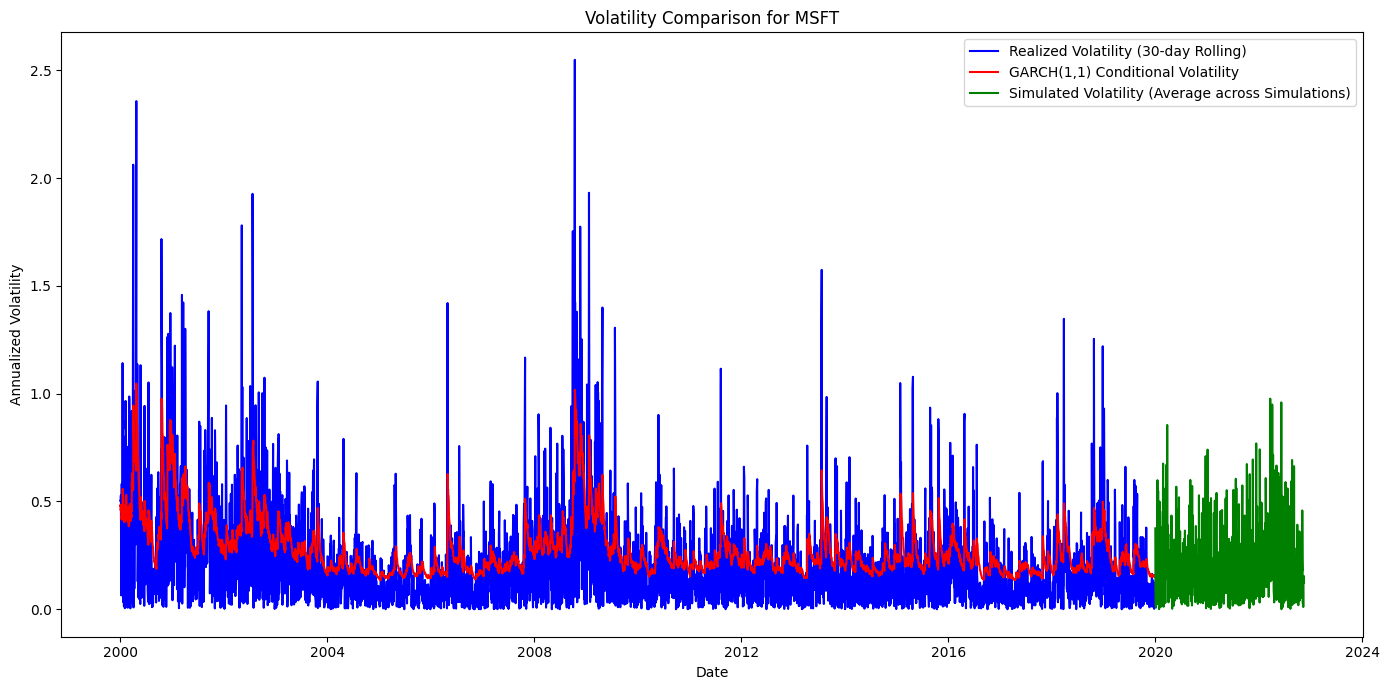

Volatility plot saved for MSFT.



[*********************100%%**********************]  1 of 1 completed


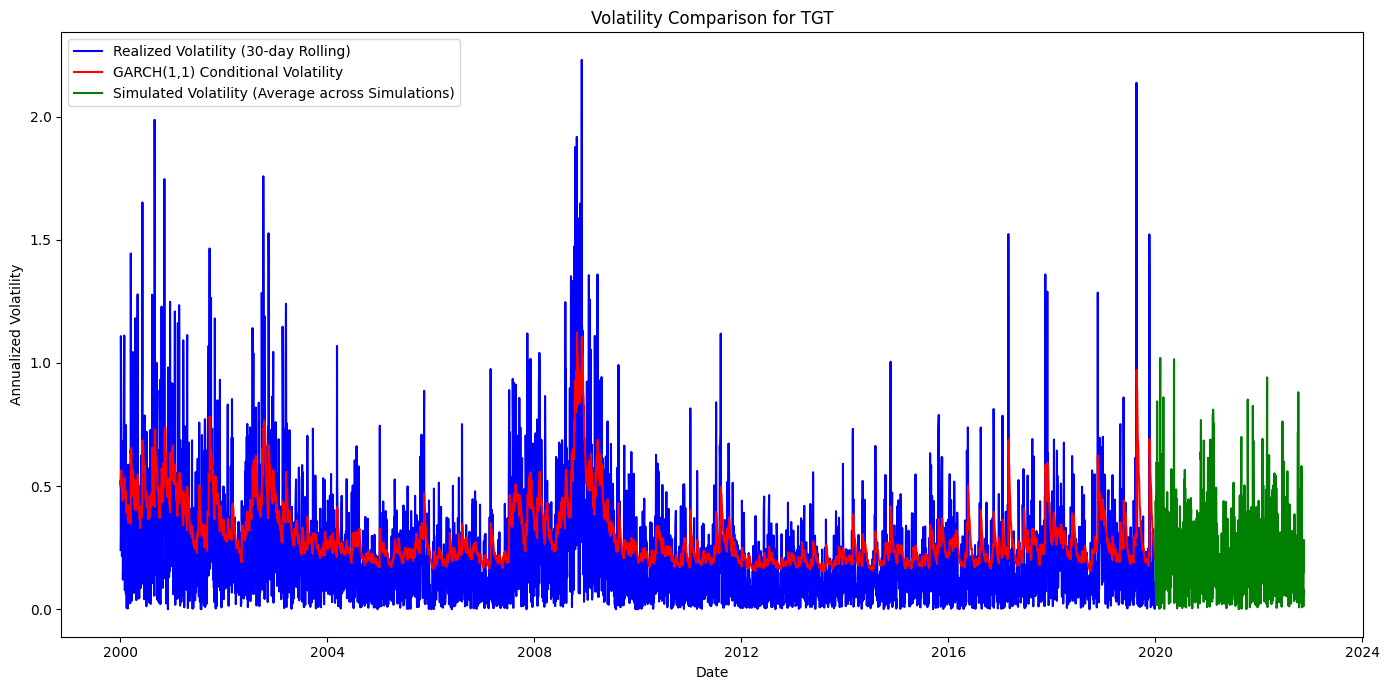

Volatility plot saved for TGT.



[*********************100%%**********************]  1 of 1 completed


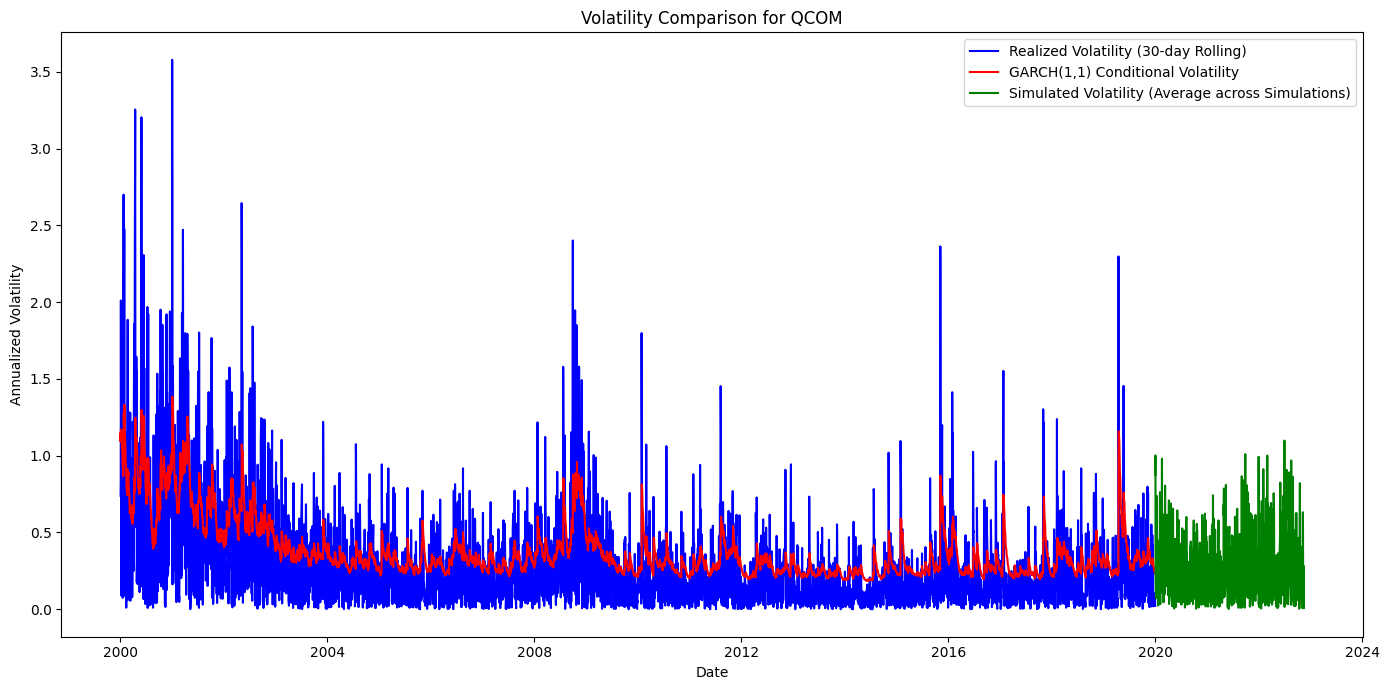

Volatility plot saved for QCOM.



[*********************100%%**********************]  1 of 1 completed


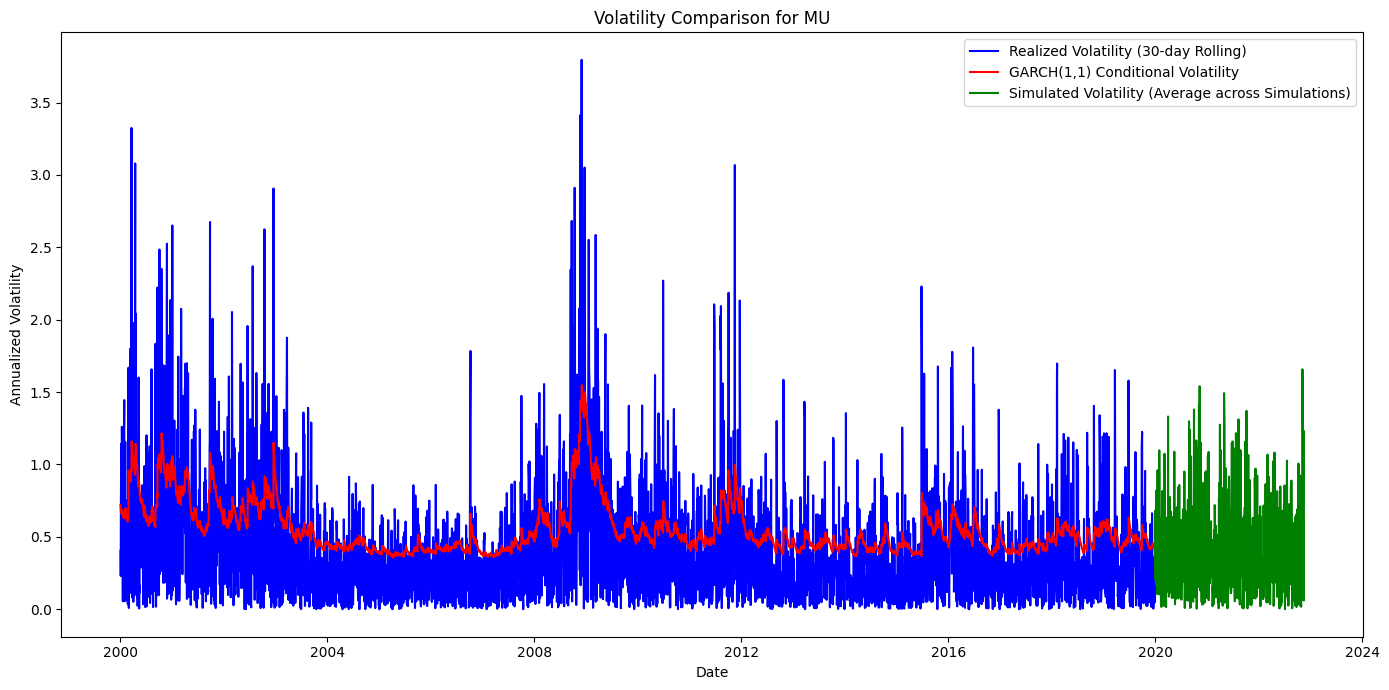

Volatility plot saved for MU.



[*********************100%%**********************]  1 of 1 completed


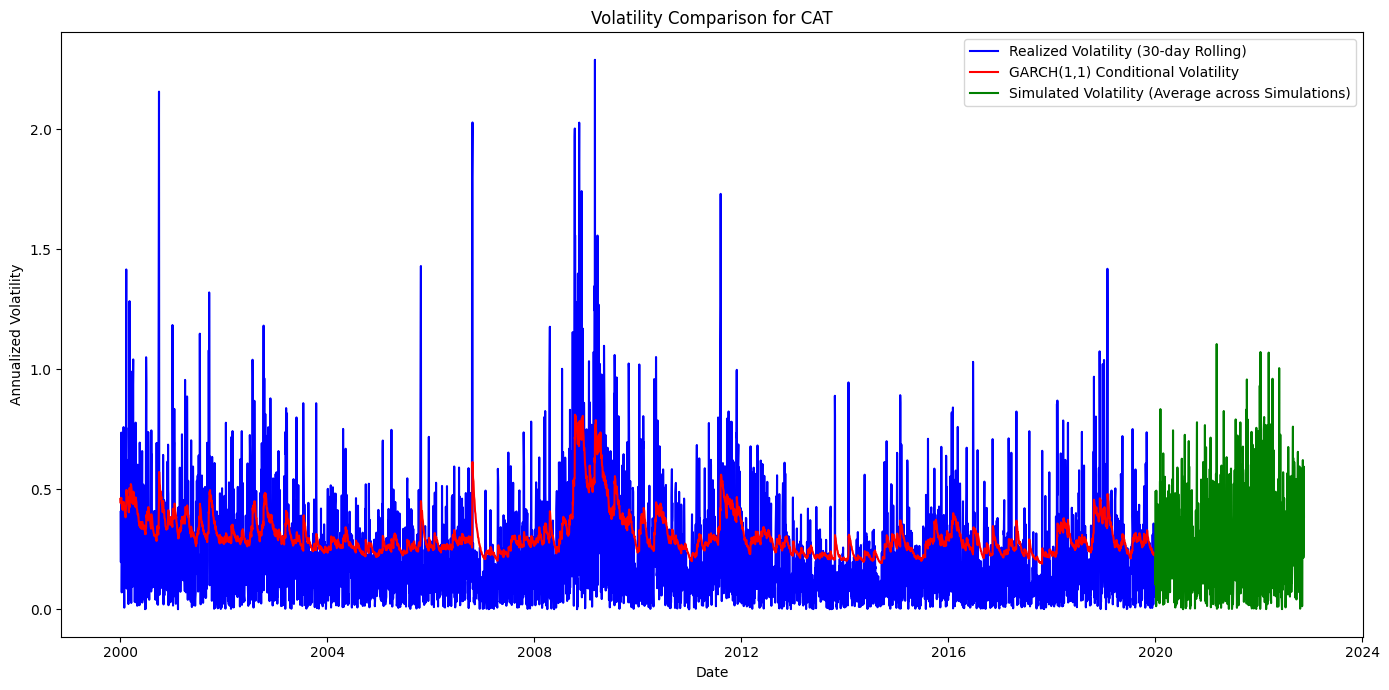

Volatility plot saved for CAT.



In [36]:
import numpy as np
import pandas as pd
import yfinance as yf
from arch import arch_model
import warnings
import matplotlib.pyplot as plt
import os

# Suppress DataScaleWarning only
warnings.filterwarnings("ignore")

np.random.seed(40)

tickers = ['MSFT', 'TGT', 'QCOM', 'MU', 'CAT']
num_simulation_episodes = 2
num_simulation_days = 750

train_simulations = int(num_simulation_episodes * 0.8)
test_simulations = num_simulation_episodes - train_simulations
initial_price = 100

# Create directories to save plots and data if they don't exist
os.makedirs("plots", exist_ok=True)
os.makedirs("data", exist_ok=True)

for ticker in tickers:
    sim_df_train = pd.DataFrame(index=range(num_simulation_days + 1), columns=range(train_simulations))
    sim_df_test = pd.DataFrame(index=range(num_simulation_days + 1), columns=range(test_simulations))

    # Download historical data
    data = yf.download(ticker, start="2000-01-01", end="2020-01-01")['Adj Close']
    log_returns = np.log(data / data.shift(1)).dropna()

    # Calculate Realized Volatility (e.g., 30-day rolling standard deviation)
    rolling_window = 2
    realized_vol = log_returns.rolling(window=rolling_window).std() * np.sqrt(252)  # Annualize

    # Fit GARCH(1,1) model
    garch = arch_model(log_returns, p=1, q=1, dist='normal')
    res = garch.fit(disp="off")
    garch_mu = res.params['mu']

    # Obtain GARCH model's conditional volatility
    garch_vol = res.conditional_volatility * np.sqrt(252)  # Annualize


    # Initialize a matrix to store simulated log returns
    simulated_log_returns_matrix = np.zeros((num_simulation_days, num_simulation_episodes))

    for i in range(num_simulation_episodes):
        # Simulate log returns using the GARCH model
        simulated = garch.simulate(res.params, num_simulation_days)
        simulated_log_returns = simulated['data'].values.flatten()
        #simulated_log_returns = simulated['volatility'].values.flatten()


        # Store simulated log returns for volatility calculation
        simulated_log_returns_matrix[:, i] = simulated_log_returns

    # Convert simulated_log_returns_matrix to daily returns in percentage terms
    simulated_returns = pd.DataFrame(simulated_log_returns_matrix)
    simulated_vol = simulated_returns.std(axis=1) * np.sqrt(252)  # Annualize

    # Align the simulated_vol index to start from the laast date in historical data
    last_date = data.index[-1]
    simulation_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=num_simulation_days)
    simulated_vol.index = simulation_dates

    # For plotting, we need to extend the historical data to include simulation period
    combined_realized_vol = pd.concat([realized_vol, simulated_vol])

    # Plotting Volatility
    plt.figure(figsize=(14, 7))

    # Plot Realized Volatility
    plt.plot(realized_vol.index, realized_vol, label='Realized Volatility (30-day Rolling)', color='blue')

    # Plot GARCH Conditional Volatility
    plt.plot(garch_vol.index, garch_vol, label='GARCH(1,1) Conditional Volatility', color='red')

    # Plot Simulated Volatility
    plt.plot(simulated_vol.index, simulated_vol, label='Simulated Volatility (Average across Simulations)', color='green')

    plt.title(f"Volatility Comparison for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Annualized Volatility")
    plt.legend()
    plt.tight_layout()

    # Save the plot
    plt.show()

    print(f"Volatility plot saved for {ticker}.\n")


[*********************100%%**********************]  1 of 1 completed


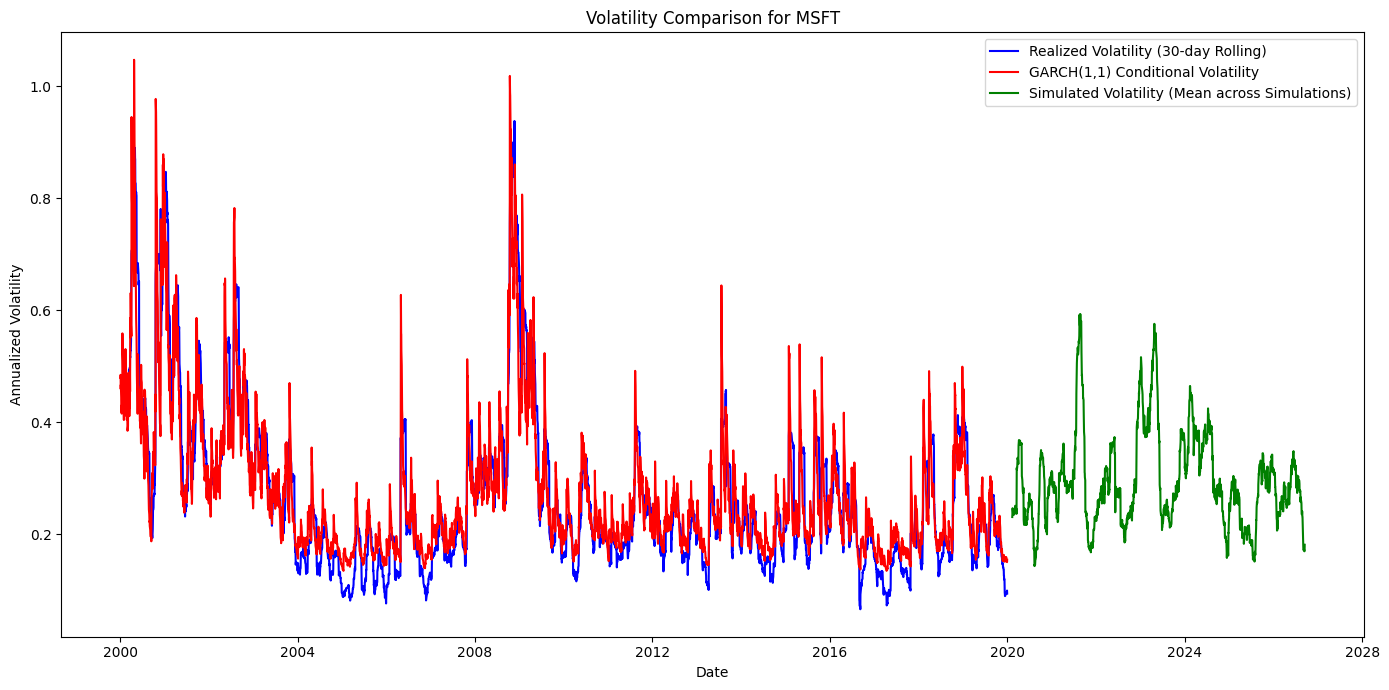

Volatility plot displayed for MSFT.



[*********************100%%**********************]  1 of 1 completed


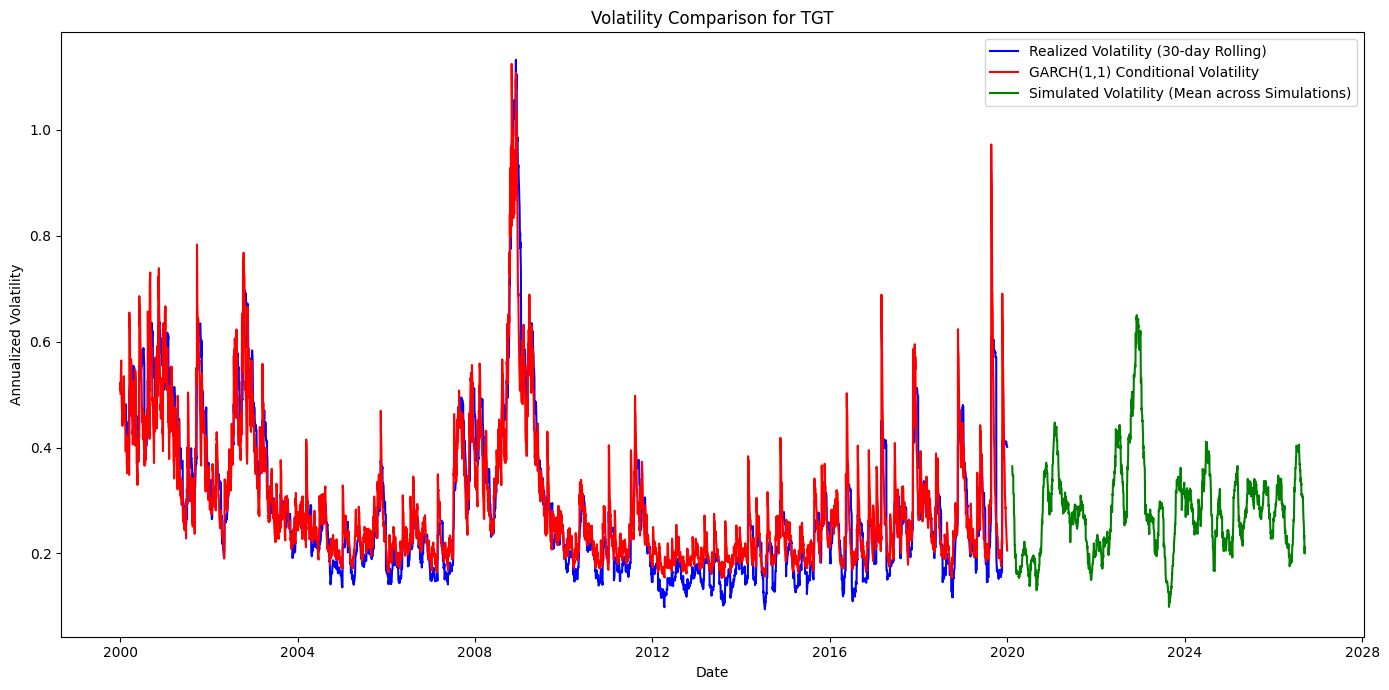

Volatility plot displayed for TGT.



[*********************100%%**********************]  1 of 1 completed


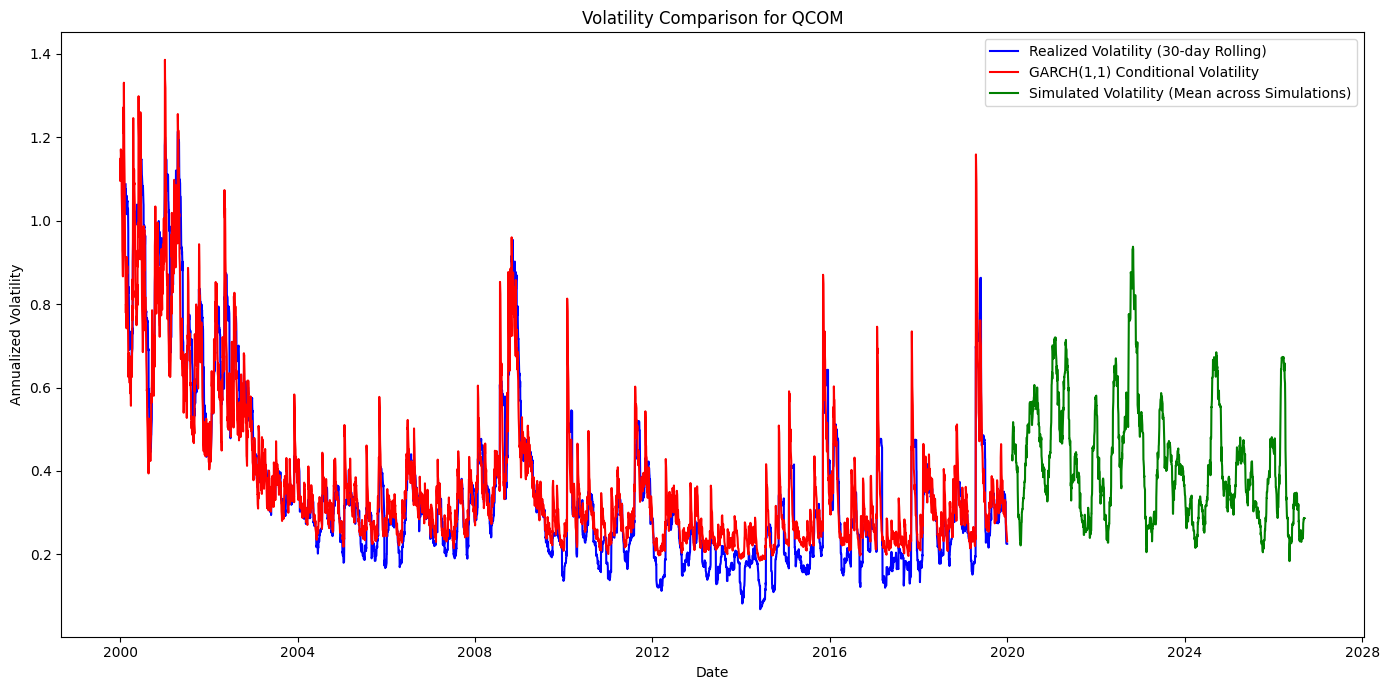

Volatility plot displayed for QCOM.



[*********************100%%**********************]  1 of 1 completed


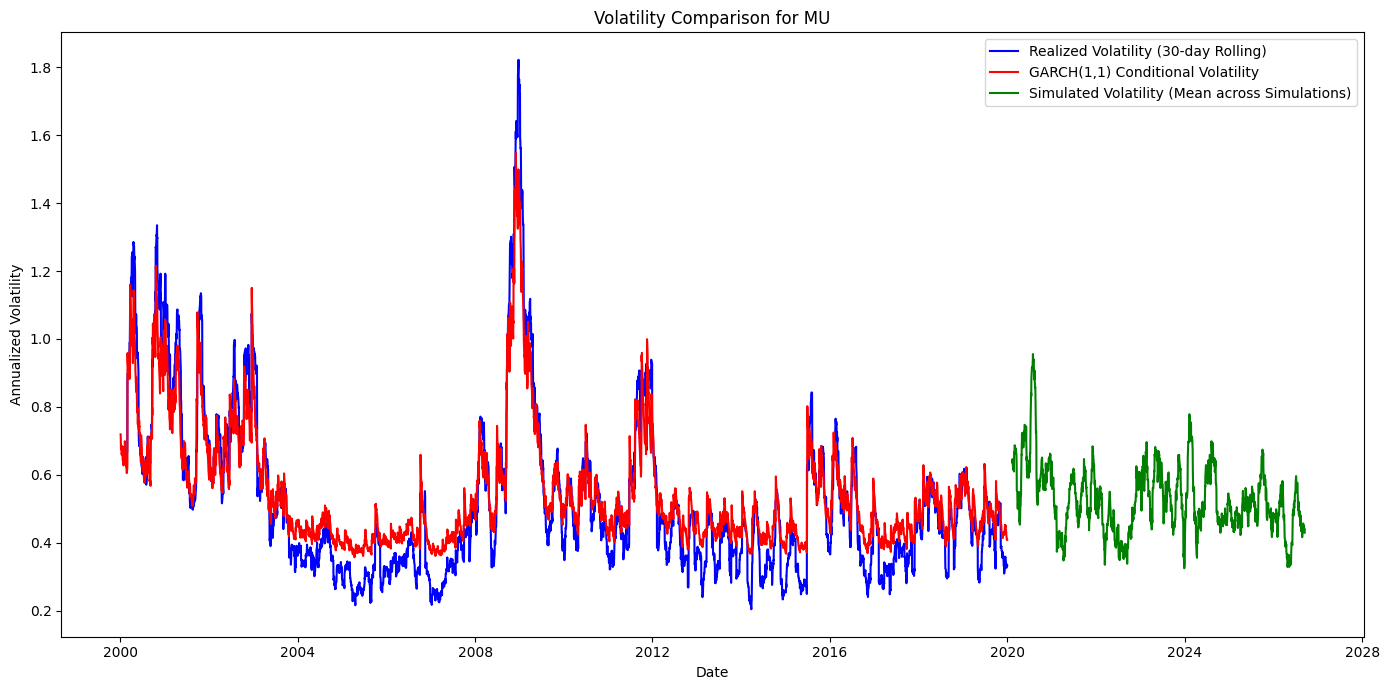

Volatility plot displayed for MU.



[*********************100%%**********************]  1 of 1 completed


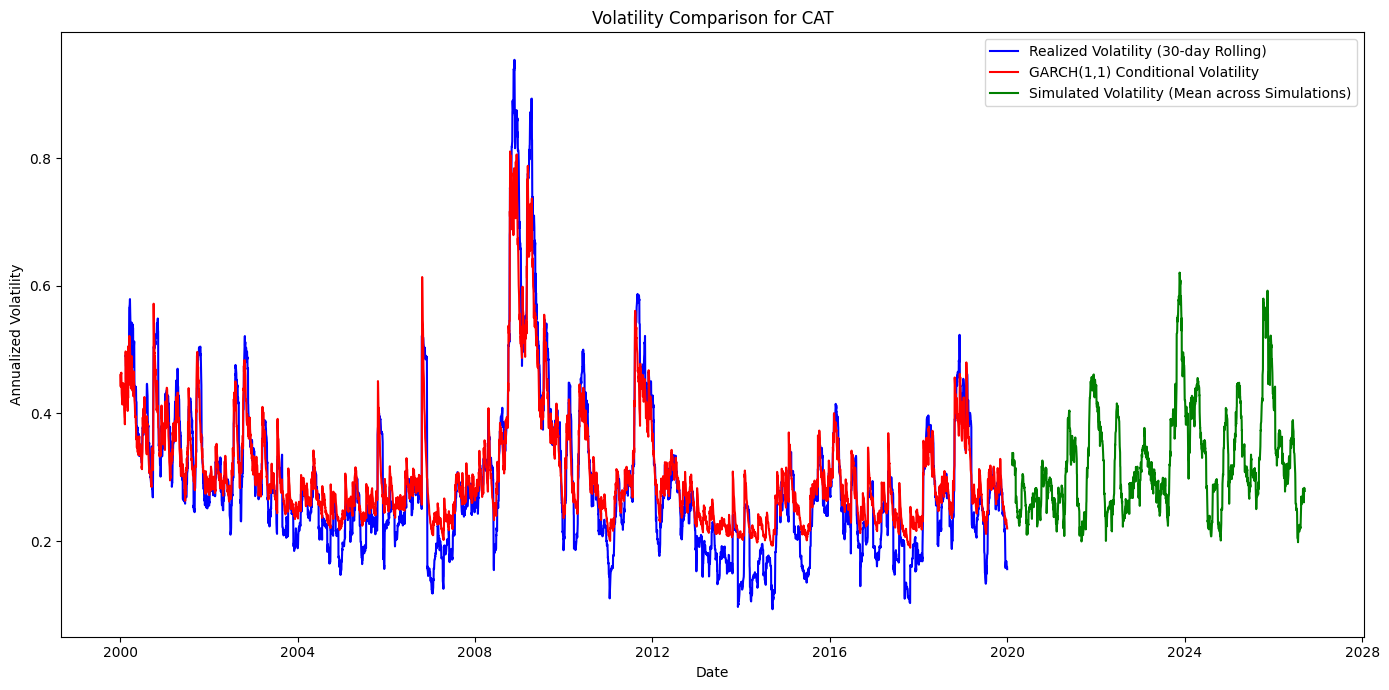

Volatility plot displayed for CAT.



In [34]:
import numpy as np
import pandas as pd
import yfinance as yf
from arch import arch_model
import warnings
import matplotlib.pyplot as plt
import os

# Suppress only specific warnings if necessary
warnings.filterwarnings("ignore")

np.random.seed(40)

tickers = ['MSFT', 'TGT', 'QCOM', 'MU', 'CAT']
num_simulation_episodes = 1  # Adjusted for demonstration; set to 500 for full simulations
num_simulation_days = 1750

train_simulations = int(num_simulation_episodes * 0.8)
test_simulations = num_simulation_episodes - train_simulations
initial_price = 100

# Create directories to save plots and data if they don't exist
os.makedirs("plots", exist_ok=True)
os.makedirs("data", exist_ok=True)

for ticker in tickers:
    # Initialize DataFrames to store simulations (adjust indices as needed)
    sim_df_train = pd.DataFrame(index=range(num_simulation_days + 1), columns=range(train_simulations))
    sim_df_test = pd.DataFrame(index=range(num_simulation_days + 1), columns=range(test_simulations))

    # Download historical data
    data = yf.download(ticker, start="2000-01-01", end="2020-01-01")['Adj Close']
    log_returns = np.log(data / data.shift(1)).dropna()

    # Fit GARCH(1,1) model
    garch = arch_model(log_returns, p=1, q=1, mean='Constant', vol='GARCH', dist='normal')
    res = garch.fit(disp="off")
    garch_mu = res.params['mu']

    # Obtain GARCH model's conditional volatility
    garch_vol = res.conditional_volatility * np.sqrt(252)  # Annualize

    # Demean historical returns by subtracting mu
    demeaned_returns = log_returns - garch_mu

    # Calculate Realized Volatility (e.g., 30-day rolling standard deviation) from demeaned returns
    rolling_window = 30
    realized_vol = demeaned_returns.rolling(window=rolling_window).std() * np.sqrt(252)  # Annualize

    # Initialize a matrix to store simulated log returns
    simulated_log_returns_matrix = np.zeros((num_simulation_days, num_simulation_episodes))

    for i in range(num_simulation_episodes):
        # Simulate log returns using the GARCH model
        simulated = garch.simulate(res.params, num_simulation_days)
        
        # Extract simulated returns and volatility separately
        simulated_returns = simulated['data'].values.flatten()
        simulated_volatility = simulated['volatility'].values.flatten()

        # Demean simulated returns by subtracting mu
        demeaned_simulated_returns = simulated_returns - garch_mu

        # Store demeaned simulated log returns for volatility calculation
        simulated_log_returns_matrix[:, i] = demeaned_simulated_returns

        # Optional: If you want to store simulated price paths
        # Calculate cumulative sum to get log prices
        cumsum = np.cumsum(demeaned_simulated_returns)
        simulated_prices = initial_price * np.exp(cumsum)

        # Store the price paths with the initial price
        simulated_prices_with_initial = pd.concat([pd.Series([initial_price]), pd.Series(simulated_prices)], ignore_index=True)

        # Split into training and testing sets
        if i < train_simulations:
            sim_df_train[i] = simulated_prices_with_initial
        else:
            sim_df_test[i - train_simulations] = simulated_prices_with_initial

    # Calculate Simulated Volatility from Simulated (Demeaned) Returns
    simulated_returns_df = pd.DataFrame(simulated_log_returns_matrix)
    simulated_vol = simulated_returns_df.rolling(window=rolling_window).std() * np.sqrt(252)  # Annualize
    simulated_vol_mean = simulated_vol.mean(axis=1)  # Average across simulations

    # Align the simulated_vol index to start from the last date in historical data
    last_date = data.index[-1]
    simulation_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=num_simulation_days)
    simulated_vol_mean.index = simulation_dates

    # For plotting, align the historical realized volatility to the simulation period
    combined_realized_vol = pd.concat([realized_vol, simulated_vol_mean])

    # Plotting Volatility
    plt.figure(figsize=(14, 7))

    # Plot Realized Volatility from Demeaned Returns
    plt.plot(realized_vol.index, realized_vol, label='Realized Volatility (30-day Rolling)', color='blue')

    # Plot GARCH Conditional Volatility
    plt.plot(garch_vol.index, garch_vol, label='GARCH(1,1) Conditional Volatility', color='red')

    # Plot Simulated Volatility from Demeaned Returns
    plt.plot(simulated_vol_mean.index, simulated_vol_mean, label='Simulated Volatility (Mean across Simulations)', color='green')

    plt.title(f"Volatility Comparison for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Annualized Volatility")
    plt.legend()
    plt.tight_layout()

    # Save the plot
    plt.show()  # Use plt.savefig(...) to save instead of showing if needed

    print(f"Volatility plot displayed for {ticker}.\n")


In [81]:

tickers = ['MSFT', 'TGT', 'QCOM', 'MU', 'CAT']

all_returns = []
log_returns = []

for ticker in tickers:
    returns = []
    sim_df = pd.read_csv(f'data/sim_test_{ticker}.csv')
    sim_df = sim_df.drop(columns=['Unnamed: 0'])
    for col in sim_df.columns:
        # Tota return
        return_col = sim_df[col].iloc[-1] / sim_df[col].iloc[0] - 1

        returns.append(return_col)

    all_returns.append(returns)

print("Mean returns for each stock")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {np.mean(all_returns[i])}")

print("Mean returns for the portfolio")
print(np.mean(np.mean(all_returns, axis=0)))

Mean returns for each stock
MSFT: 0.9188623888168966
TGT: 0.5731229585107581
QCOM: 0.9656569790592039
MU: 1.2318741412951595
CAT: 1.3013502879917112
Mean returns for the portfolio
0.9981733511347458


In [80]:
print("Mean returns for each stock")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {np.mean(all_returns[i])}")

print("Mean returns for the portfolio")
print(np.mean(np.mean(all_returns, axis=0)))

Mean returns for each stock
MSFT: 0.9363715432014069
TGT: 0.6468458350423893
QCOM: 1.3040967567144321
MU: 1.5948915535360004
CAT: 0.8203233316037971
Mean returns for the portfolio
1.060505804019605


[*********************100%%**********************]  1 of 1 completed


MSFT: First Value = 35.94, Last Value = 151.14, Number of Years = 28.98, Annual Return = 5.08%


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


TGT: First Value = 22.34, Last Value = 115.03, Number of Years = 28.98, Annual Return = 5.82%
QCOM: First Value = 57.08, Last Value = 79.39, Number of Years = 28.98, Annual Return = 1.15%


[*********************100%%**********************]  1 of 1 completed


MU: First Value = 37.22, Last Value = 52.71, Number of Years = 28.98, Annual Return = 1.21%


[*********************100%%**********************]  1 of 1 completed


CAT: First Value = 12.76, Last Value = 132.33, Number of Years = 28.98, Annual Return = 8.41%


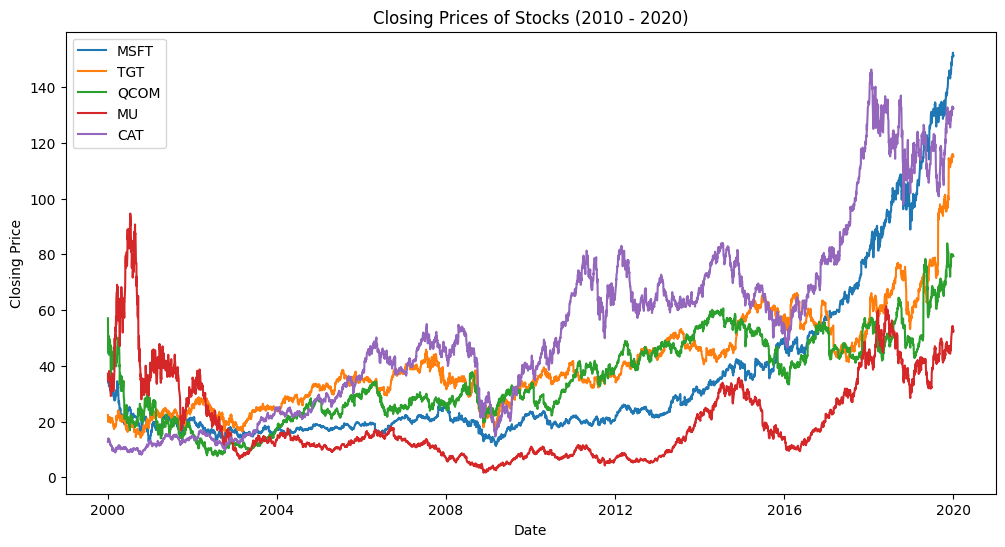

In [68]:
import yfinance as yf
import matplotlib.pyplot as plt

# Parameters
tickers = ['MSFT', 'TGT', 'QCOM', 'MU', 'CAT']
start_date = "2000-01-01"
end_date = "2020-01-01"

# Download and plot closing prices for each ticker
plt.figure(figsize=(12, 6))
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
    # Plot data
    plt.plot(data, label=ticker)
    
    # Calculate and print first, last values and number of years
    first_value = data.iloc[0]
    last_value = data.iloc[-1]
    num_years = (data.index[-1] - data.index[0]).days / 252
    annual_return = (last_value / first_value) ** (1 / num_years) - 1
    print(f"{ticker}: First Value = {first_value:.2f}, Last Value = {last_value:.2f}, Number of Years = {num_years:.2f}, Annual Return = {annual_return:.2%}")

# Display plot
plt.title("Closing Prices of Stocks (2000 - 2020)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

MSFT: First Value = 153.94, Last Value = 374.00, Number of Years = 3.99, Annual Return = 24.90%
TGT: First Value = 113.11, Last Value = 139.32, Number of Years = 3.99, Annual Return = 5.36%
QCOM: First Value = 79.80, Last Value = 142.57, Number of Years = 3.99, Annual Return = 15.65%



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


MU: First Value = 54.29, Last Value = 85.09, Number of Years = 3.99, Annual Return = 11.91%
CAT: First Value = 134.88, Last Value = 291.00, Number of Years = 3.99, Annual Return = 21.24%
Mean returns for the portfolio
0.8345121594290233


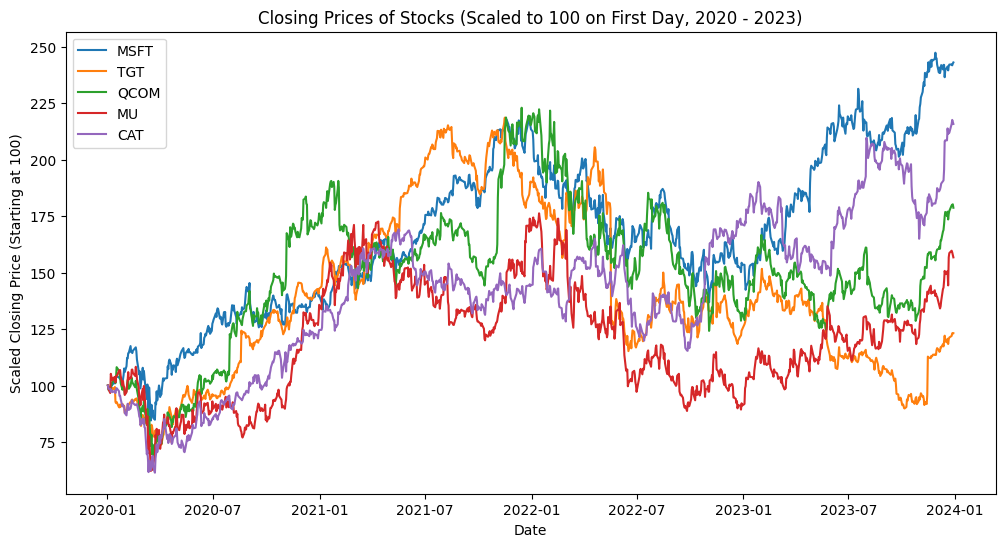

In [83]:
import yfinance as yf
import matplotlib.pyplot as plt

# Parameters
tickers = ['MSFT', 'TGT', 'QCOM', 'MU', 'CAT']
start_date = "2020-01-01"
end_date = "2023-12-31"

returns = []
# Download and plot closing prices for each ticker, scaled to start at 100
plt.figure(figsize=(12, 6))
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
    
    # Scale prices to start at 100
    scaled_data = (data / data.iloc[0]) * 100
    
    # Plot scaled data
    plt.plot(scaled_data, label=ticker)
    
    # Calculate first, last values, number of years, and annual return
    first_value = data.iloc[0]
    last_value = data.iloc[-1]
    num_years = (data.index[-1] - data.index[0]).days / 365  # Trading days in a year
    annual_return = (last_value / first_value) ** (1 / num_years) - 1
    print(f"{ticker}: First Value = {first_value:.2f}, Last Value = {last_value:.2f}, Number of Years = {num_years:.2f}, Annual Return = {annual_return:.2%}")
    returns.append((last_value / first_value )-1)

print("Mean returns for the portfolio")
print(np.mean(returns))

# Display plot
plt.title("Closing Prices of Stocks (Scaled to 100 on First Day, 2020 - 2023)")
plt.xlabel("Date")
plt.ylabel("Scaled Closing Price (Starting at 100)")
plt.legend()
plt.show()
